# Flight Price Forecast – Kayak

## Table of Contents
- [Introduction](#introduction)
- [Imports](#imports)
- [Data Preprocessing](#data-preprocessing)
- [Linear Regression](#linear-regression)
- [Decision Tree](#decision-tree)
- [Gaussian Process Regression](#gaussian-process-regression)
- [Random Forest](#random-forest)
- [GridSearchCV](#gridsearchcv)
- [KNN Regressor](#knn-regressor)
- [MLP Regressor](#mlp-regressor)
- [XG Boost Regressor](#xg-boost-regressor)
- [Hist Gradient Boosting](#hist-gradient-boosting)
- [Best Performance with Best Parameters](#best-performance-with-best-parameters)
- [Feature Importance](#feature-importance)
- [Conclusions](#conclusions)

---

## Introduction

The provided Python code develops a machine learning pipeline for predicting flight prices, starting with data preprocessing such as cleaning and converting price data, date extraction, duration conversion, and numeric encoding of categorical features like flight stops.  
The pipeline evaluates multiple regression methods, including Linear Regression, Decision Trees, Gaussian Process, Random Forests (with GridSearchCV optimization), K-Nearest Neighbors, Multi-layer Perceptron, XGBoost, and HistGradientBoostingRegressor, comparing their performance using metrics like R², RMSE, MSE, and MAE.

**Our Top models:** *"Random Forest"*, *"XGBoost"*, and *"HistGradientBoosting"* regressors demonstrated the strongest predictive performances, while significantly outperforming basic linear models.  
Using visualization tools such as residual plots, permutation importance, and predicted-versus-actual graphs provided insights into model accuracy and feature relevance.


# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.inspection import permutation_importance

from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Data Preprocessing

In [3]:

df = pd.read_csv('kayak_cleaned.csv')


print(df.head())
print(df.info())

   departure_hour departure_airport  flight_length  landing_hour  \
0       13.833333               LGW             75     16.083333   
1       18.166667               LGW             80     20.500000   
2       16.166667               LGW             75     18.416667   
3       16.516667               LON            138     19.816667   
4       12.750000               LGW             80     15.083333   

  landing_airport to_dest_company  return_departure_hour  \
0             CDG         easyJet              21.166667   
1             CDG         easyJet              10.250000   
2             ORY         Vueling              16.583333   
3             PAR        Eurostar               7.150000   
4             ORY         Vueling              16.000000   

  return_departure_airport  return_flight_length  return_landing_hour  ...  \
0                      CDG                    65            21.250000  ...   
1                      CDG                    80            10.583333  ...

In [4]:

df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace('"', '', regex=False)
df['price'] = df['price'].str.replace("'", '', regex=False)
df['price'] = df['price'].str.replace(",", '', regex=False)
df['price'] = df['price'].str.strip()

# 2. המרה ל־float
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# 3. הסרה של שורות בלי מחיר
df = df.dropna(subset=['price'])

# 4. בדיקה
print(df['price'].dtype)  # אמור להיות float64
print(df.shape)           # כמה שורות נשארו
        # כמה שורות נשארו


float64
(85764, 27)


In [5]:
df['snapshot_date'] = pd.to_datetime(df['snapshot_date'])
df['departure_date'] = pd.to_datetime(df['departure_date'])
df['return_date'] = pd.to_datetime(df['return_date'])

df['dep_weekday'] = df['departure_date'].dt.weekday
df['dep_day'] = df['departure_date'].dt.day
df['dep_month'] = df['departure_date'].dt.month
df['is_weekend'] = df['dep_weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [6]:
df['ttt'] = (df['departure_date'] - df['snapshot_date']).dt.days

In [7]:
df['Stops'] = df['layover'].astype(int)

In [8]:
features = ['Stops', 'flight_length', 'layover_time',
            'dep_weekday', 'dep_day', 'dep_month']

df.dropna(subset=features, inplace=True)


In [9]:
df.to_csv('kayak_final.csv', index=False)


In [10]:
pd.read_csv('kayak_final.csv').head()



departure_hour departure_airport  flight_length  landing_hour  \
0       13.833333               LGW             75     16.083333   
1       18.166667               LGW             80     20.500000   
2       16.166667               LGW             75     18.416667   
3       16.516667               LON            138     19.816667   
4       12.750000               LGW             80     15.083333   

  landing_airport to_dest_company  return_departure_hour  \
0             CDG         easyJet              21.166667   
1             CDG         easyJet              10.250000   
2             ORY         Vueling              16.583333   
3             PAR        Eurostar               7.150000   
4             ORY         Vueling              16.000000   

  return_departure_airport  return_flight_length  return_landing_hour  ...  \
0                      CDG                    65            21.250000  ...   
1                      CDG                    80            10.583333  ...   
2                      CDG                    65            16.666667  ...   
3                      PAR                   141             8.500000  ...   
4                      CDG                    75            16.250000  ...   

  layover_time return_layover_time  day_of_week         route  \
0            0                   0       Sunday  LONDON_PARIS   
1            0                   0     Thursday  LONDON_PARIS   
2            0                   0      Tuesday  LONDON_PARIS   
3           53                  51      Tuesday  LONDON_PARIS   
4            0                   0     Saturday  LONDON_PARIS   

     time_category  dep_weekday dep_day dep_month is_weekend Stops  
0  Afternoon_12_18            6       2         3          1     0  
1    Evening_18_24            3      20         3          0     0  
2  Afternoon_12_18            1       4         3          0     0  
3  Afternoon_12_18            1      11         3          0     1  
4  Afternoon_12_18            5       1         3          1     0  

[5 rows x 32 columns]

In [11]:

nan_summary = df.isna().sum().sort_values(ascending=False)
nan_summary = nan_summary[nan_summary > 0]
display(nan_summary)


Series([], dtype: int64)

In [12]:
return_columns = [col for col in df.columns if 'return' in col]
return_columns

['return_departure_hour',
 'return_departure_airport',
 'return_flight_length',
 'return_landing_hour',
 'return_landing_airport',
 'return_company',
 'return_date',
 'return_layover_time']

In [13]:
df.drop(columns=return_columns, inplace=True)

In [14]:
df.to_csv("kayak_cleaned_final.csv", index=False)

# Model Training

In [15]:

features = ['Stops', 'flight_length', 'layover_time',
            'dep_weekday', 'dep_day', 'dep_month']


train_df = df[df['ttt'] <= 25].copy()
test_df = df[df['ttt'] > 25].copy()


X_train = train_df[features]
y_train = train_df['price']

X_test = test_df[features]
y_test = test_df['price']


In [16]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (78743, 6)
Test shape: (7021, 6)


In [17]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    
    model.fit(X_train, y_train)
    
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
   
    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test  = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    
    print(f"=== {model_name} ===")
    print(f"Train -> R2: {r2_train:.3f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
    print(f"Test  -> R2: {r2_test:.3f},  MSE: {mse_test:.2f},  RMSE: {rmse_test:.2f},  MAE: {mae_test:.2f}")
    
    
    residuals = y_test - y_pred_test
    abs_residuals = np.abs(residuals)

    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        x=y_pred_test,
        y=residuals,
        hue=abs_residuals,
        palette='coolwarm',
        size=abs_residuals,
        sizes=(20, 200),
        alpha=0.7,
        edgecolor='black',
        legend=False
    )

    plt.axhline(0, color='gray', linestyle='--', linewidth=1.5)
    plt.title(f" {model_name} – Residual Plot (Test)", fontsize=13)
    plt.xlabel("Predicted Price", fontsize=11)
    plt.ylabel("Residual (y_test - y_pred)", fontsize=11)
    plt.grid(True, linestyle='--', linewidth=0.4)
    plt.tight_layout()
    plt.show()
    
    return model

# Linear Regression

=== Linear Regression ===
Train -> R2: 0.151, MSE: 3131.62, RMSE: 55.96, MAE: 45.28
Test  -> R2: -0.215,  MSE: 2795.91,  RMSE: 52.88,  MAE: 41.88


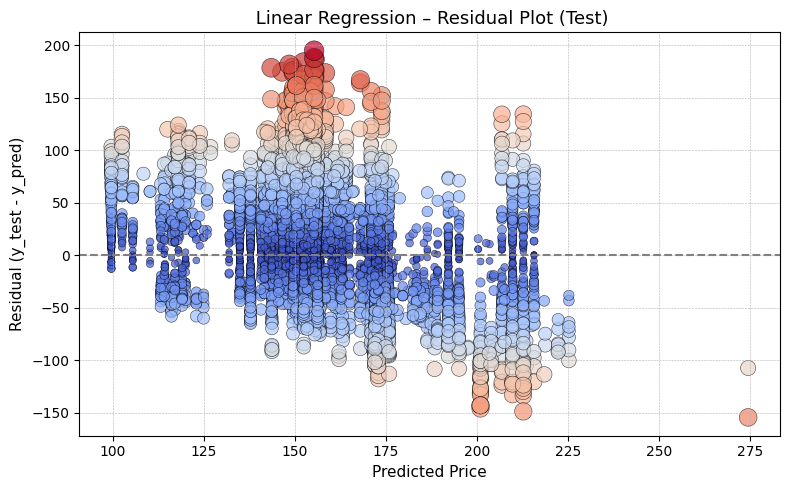

=== Linear Regression (StandardScaler) ===
Train -> R2: 0.151, MSE: 3131.62, RMSE: 55.96, MAE: 45.28
Test  -> R2: -0.215,  MSE: 2795.91,  RMSE: 52.88,  MAE: 41.88


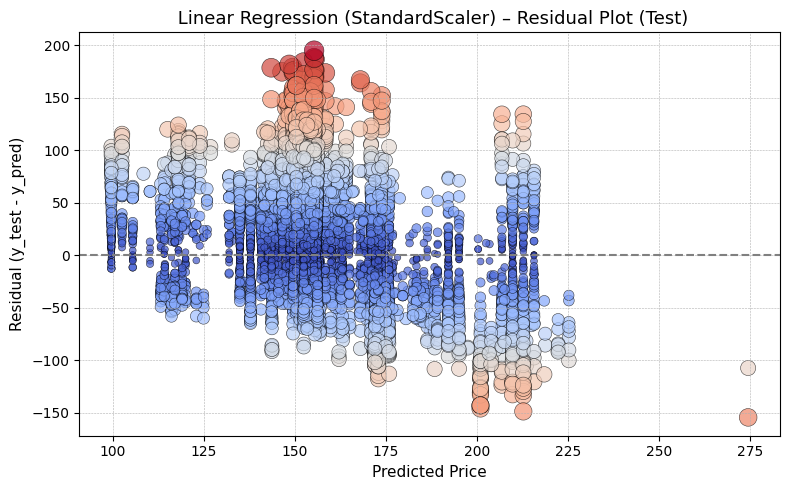

=== Linear Regression (MinMaxScaler) ===
Train -> R2: 0.151, MSE: 3131.62, RMSE: 55.96, MAE: 45.28
Test  -> R2: -0.215,  MSE: 2795.91,  RMSE: 52.88,  MAE: 41.88


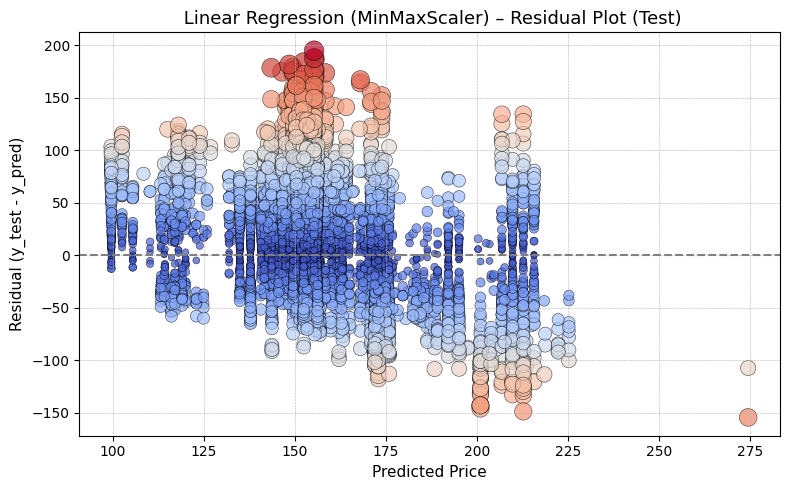

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. מודל לינארי רגיל
linreg = LinearRegression()
linreg = train_and_evaluate_model(linreg, X_train, y_train, X_test, y_test, "Linear Regression")

# 2. מודל לינארי עם StandardScaler
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

linreg_std = LinearRegression()
linreg_std = train_and_evaluate_model(linreg_std, X_train_std, y_train, X_test_std, y_test, "Linear Regression (StandardScaler)")

# 3. מודל לינארי עם MinMaxScaler
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

linreg_mm = LinearRegression()
linreg_mm = train_and_evaluate_model(linreg_mm, X_train_mm, y_train, X_test_mm, y_test, "Linear Regression (MinMaxScaler)")


## Conclusions – Linear Regression on Kayak Data

Despite testing three versions of linear regression (raw, StandardScaler, MinMaxScaler), results were consistently poor.

### Key Results:
- **R² (Train):** 0.151  
- **R² (Test):** –0.215 → Indicates the model performs worse than predicting the mean.
- **RMSE (Test):** 52.88  
- **MAE (Test):** 41.88

### Insights:
- The residuals display clear patterns, violating the assumption of randomness.
- All models underfit the data and fail to capture key relationships.

### Conclusion:
Linear regression is not suitable for this dataset.  
The low explanatory power and structured residuals indicate the need for non-linear models such as Random Forest or Gradient Boosting.



# Decision-Tree

=== Decision Tree (max_depth=3) ===
Train -> R2: 0.330, MSE: 2470.43, RMSE: 49.70, MAE: 39.70
Test  -> R2: -0.119,  MSE: 2574.38,  RMSE: 50.74,  MAE: 40.54


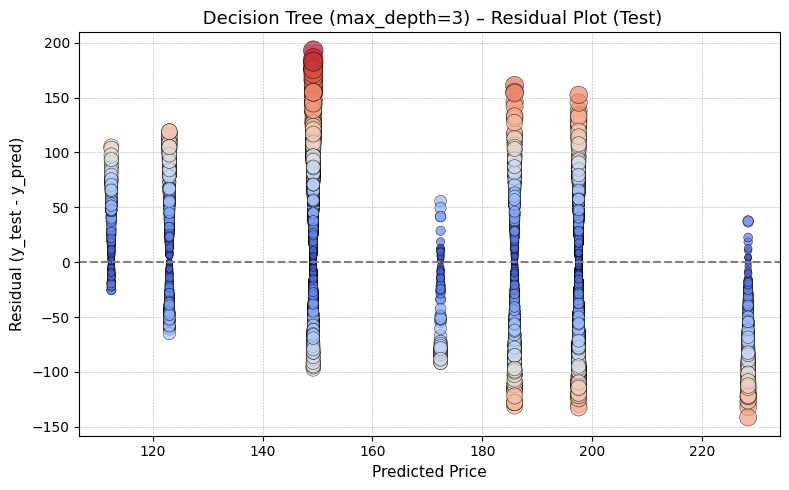

=== Decision Tree (max_depth=5) ===
Train -> R2: 0.381, MSE: 2282.74, RMSE: 47.78, MAE: 38.13
Test  -> R2: -0.122,  MSE: 2581.08,  RMSE: 50.80,  MAE: 40.41


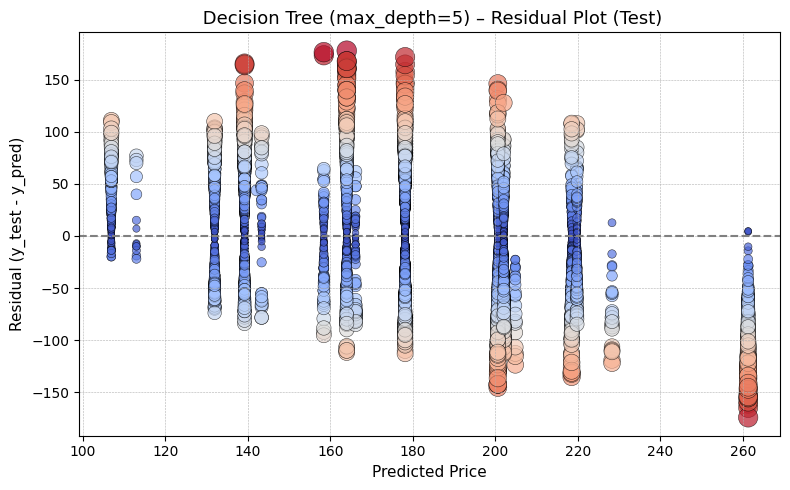

=== Decision Tree (max_depth=7) ===
Train -> R2: 0.429, MSE: 2107.01, RMSE: 45.90, MAE: 36.61
Test  -> R2: -0.159,  MSE: 2666.84,  RMSE: 51.64,  MAE: 40.28


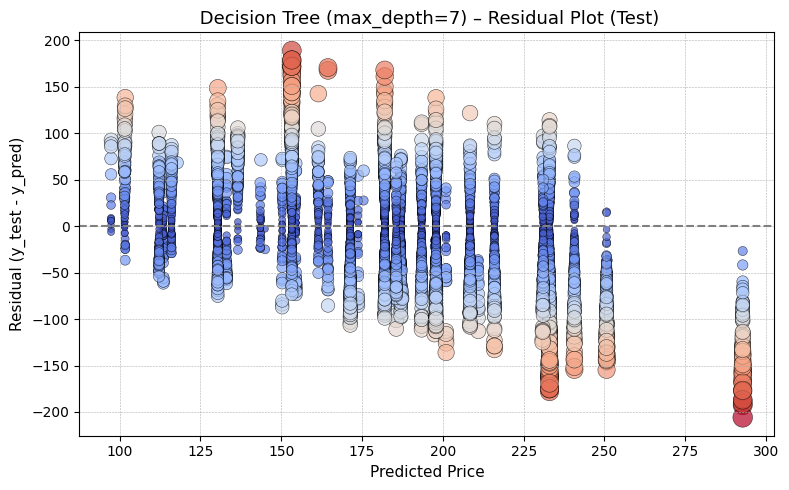

In [19]:
from sklearn.tree import DecisionTreeRegressor

for max_depth in [3, 5, 7]:
    dt = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    model_name = f"Decision Tree (max_depth={max_depth})"
    dt = train_and_evaluate_model(dt, X_train, y_train, X_test, y_test, model_name)


### Decision Tree – Conclusions (Kayak)

The Decision Tree models with increasing `max_depth` (3, 5, 7) demonstrated the following:

- **Test performance was poor across all depths**, with negative R² values:
  - R²(Test) ≈ -0.119 to -0.159 → the model fails to explain variance in test data.
- **Train R² improved** from 0.330 to 0.429 as depth increased, indicating growing model complexity.
- **Overfitting observed**: despite higher train scores, the test performance deteriorated.
- **Error metrics on test set remained high and consistent**:
  - RMSE ≈ 51, MAE ≈ 40
- **Residual plots exhibit structured patterns**, suggesting the model misses key relationships in the data.

#### Insight:
The Decision Tree models tend to **overfit the training data** while generalizing poorly. Future improvements could involve using ensemble methods (e.g., Random Forest, Gradient Boosting) or engineering more informative features.


# Gaussian Process Regression

=== GPR with RBF(length_scale=1) ===
Train -> R2: 0.662, MSE: 675.03, RMSE: 25.98, MAE: 18.08
Test  -> R2: -12.919,  MSE: 32025.85,  RMSE: 178.96,  MAE: 172.39


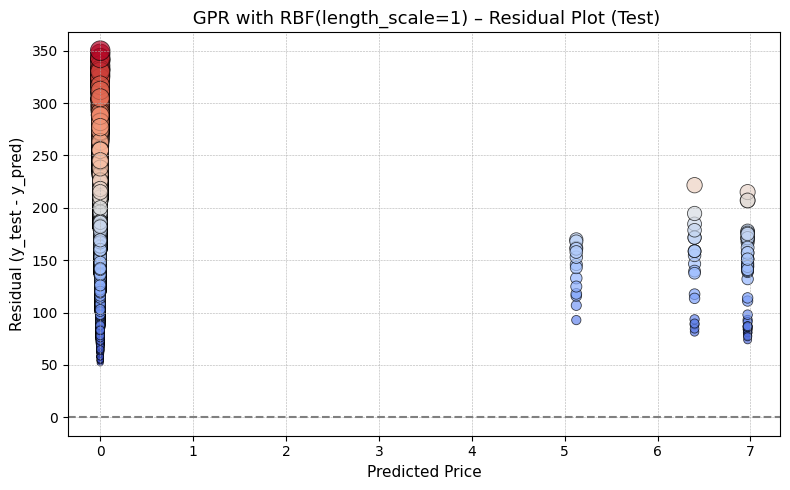

=== GPR with DotProduct(sigma_0=1) ===
Train -> R2: 0.168, MSE: 1663.18, RMSE: 40.78, MAE: 31.45
Test  -> R2: -0.920,  MSE: 4416.70,  RMSE: 66.46,  MAE: 52.97


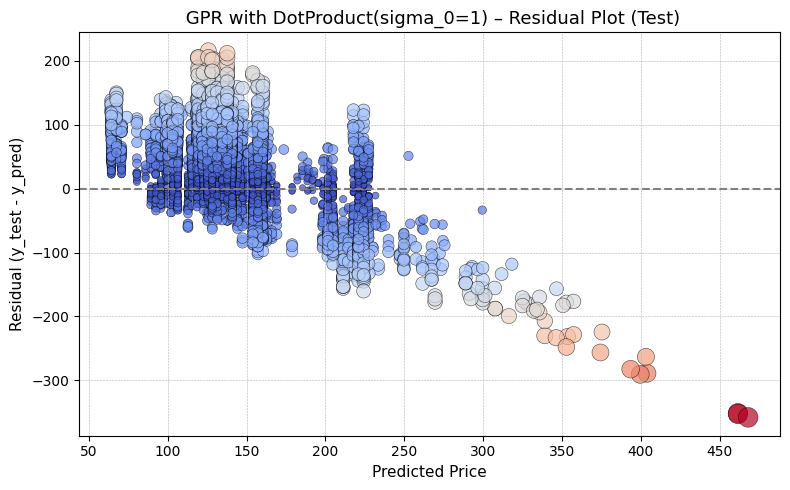

In [20]:
subset_size = 100  
X_train_sub = X_train[:subset_size]
y_train_sub = y_train[:subset_size]

for kernel in [RBF(length_scale=1.0), DotProduct()]:
    try:
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            optimizer=None,       
            alpha=1e-6,           
        )
        model_name = f"GPR with {kernel}"
        gpr = train_and_evaluate_model(gpr, X_train_sub, y_train_sub, X_test, y_test, model_name)
    except Exception as e:
        print(f"Error with kernel {kernel}: {e}")

### Gaussian Process Regression – Conclusions (Kayak)

Two kernel types were tested on a reduced training set (n=100):

#### 1. RBF Kernel (length_scale=1)
- **Train R²**: 0.662 – Model fits well on the small train set.
- **Test R²**: -12.919 – Severe overfitting, generalization failed.
- **Test RMSE**: 178.96, **MAE**: 172.39 – Huge prediction errors.
- **Observation**: The model fails completely on unseen data, likely due to the small sample size and the complexity of RBF on this data structure.

#### 2. DotProduct Kernel
- **Train R²**: 0.168 – Poor fit even on the training subset.
- **Test R²**: -0.920 – Model performs worse than a constant mean predictor.
- **Test RMSE**: 66.46, **MAE**: 52.97 – High prediction error.
- **Observation**: DotProduct also fails to capture useful trends in the data, both train and test performance are weak.

---

### Summary
- Both kernels performed **poorly** on the test data.
- The **RBF kernel severely overfitted**, while **DotProduct underfit** the data entirely.
- **GPR is not suitable for this dataset at this scale**, unless more data or careful kernel tuning is applied.

# Random Forest


=== Random Forest (max_depth=3) ===
Train -> R2: 0.331, MSE: 2465.70, RMSE: 49.66, MAE: 39.66
Test  -> R2: -0.120,  MSE: 2577.02,  RMSE: 50.76,  MAE: 40.55


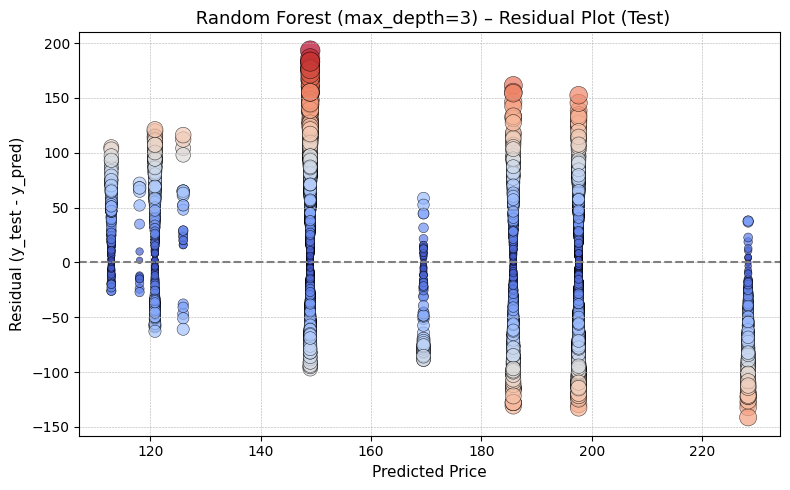

=== Random Forest (max_depth=5) ===
Train -> R2: 0.385, MSE: 2267.18, RMSE: 47.61, MAE: 38.01
Test  -> R2: -0.143,  MSE: 2630.37,  RMSE: 51.29,  MAE: 40.73


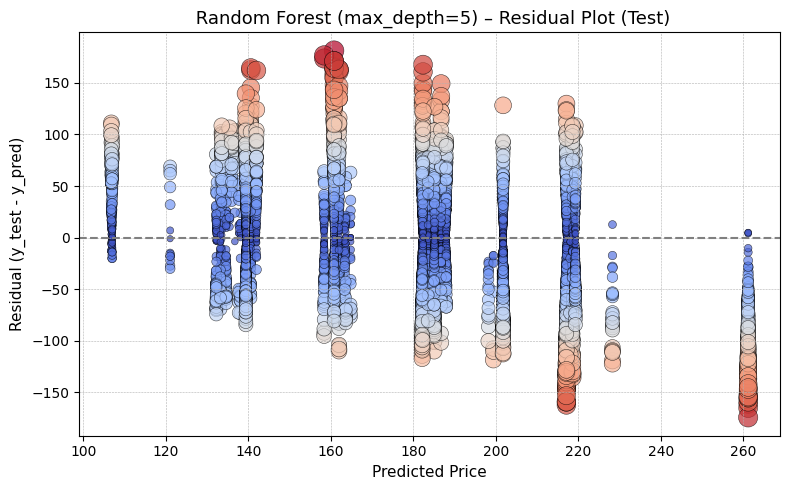

=== Random Forest (max_depth=8) ===
Train -> R2: 0.464, MSE: 1976.10, RMSE: 44.45, MAE: 35.37
Test  -> R2: -0.141,  MSE: 2625.63,  RMSE: 51.24,  MAE: 39.74


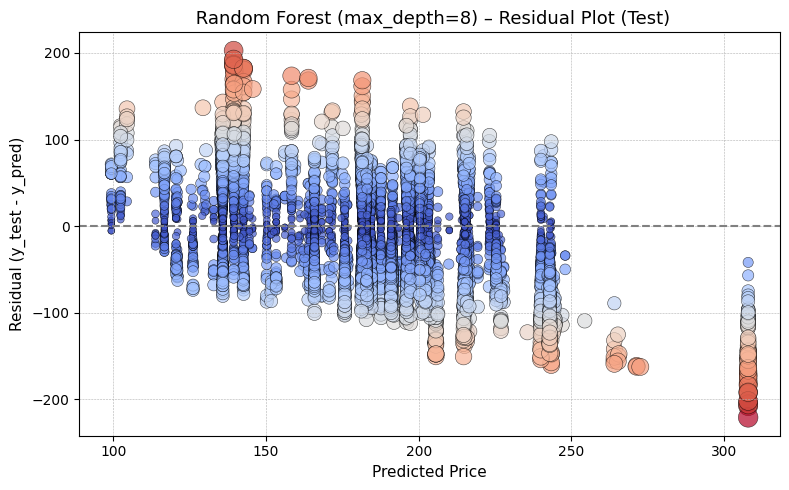

In [21]:
from sklearn.ensemble import RandomForestRegressor


max_depth_list = [3, 5, 8]


for md in max_depth_list:
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=md,
        random_state=42
    )
    model_name = f"Random Forest (max_depth={md})"
    trained_rf = train_and_evaluate_model(
        rf, X_train, y_train, X_test, y_test, model_name
    )


### Conclusions – Random Forest (Kayak)

**Performance Summary:**  
The Random Forest Regressor demonstrated moderate learning capacity on the training set, with **R² values around 0.33–0.46**. However, all models failed to generalize, showing **negative R² on the test set** (e.g., -0.141 for max_depth=8), indicating **poor predictive performance**.

---

**Key Observations:**
- Residuals remain scattered and non-random → systematic errors persist.
- Increasing `max_depth` slightly improved training fit but did **not help test accuracy**.
- MAE values (~40) are relatively high and stable across all depths.

**Conclusion:**  
Random Forest models do not effectively capture the complexity of the Kayak data. Further tuning, feature engineering, or alternative model types are recommended.


# GridSearchCV
(A systematic search to find the combination that yields better performance)

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


param_grid_rfm = {
    'max_depth': [3, 5, 7, 10, 12, 15],
    'n_estimators': [50, 100, 150, 200],
    'min_samples_split': [2, 3, 5, 7, 9, 10]
}

param_grid_lr = {
    'fit_intercept': [True, False]
}


model_rfm = RandomForestRegressor(random_state=42)
model_lr = LinearRegression()


grid_search_rfm = GridSearchCV(
    estimator=model_rfm,
    param_grid=param_grid_rfm,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_lr = GridSearchCV(
    estimator=model_lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)


print("Training RandomForestRegressor...")
grid_search_rfm.fit(X_train, y_train)

print("\nTraining LinearRegression...")
grid_search_lr.fit(X_train, y_train)


print("\nBest Parameters for RandomForestRegressor:", grid_search_rfm.best_params_)
print("Best Score (MSE):", -grid_search_rfm.best_score_)

print("\nBest Parameters for LinearRegression:", grid_search_lr.best_params_)
print("Best Score (MSE):", -grid_search_lr.best_score_)


Training RandomForestRegressor...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Training LinearRegression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Parameters for RandomForestRegressor: {'max_depth': 12, 'min_samples_split': 10, 'n_estimators': 150}
Best Score (MSE): 2243.8133467690477

Best Parameters for LinearRegression: {'fit_intercept': False}
Best Score (MSE): 3819.234000363431


### Grid Search Summary Kayak

After performing GridSearchCV:

- **RandomForestRegressor** performed best with:
  - `max_depth=12`, `min_samples_split=10`, `n_estimators=150`
  - **Best Cross-Validated MSE**: 2243.81

- **LinearRegression** achieved its best with:
  - `fit_intercept=False`
  - **Best Cross-Validated MSE**: 3819.23

 **Conclusion:**  
The Random Forest model significantly outperformed Linear Regression based on cross-validated MSE, indicating a better fit for our prediction task.


=== Random Forest (Best from GridSearch) ===
Train -> R2: 0.505, MSE: 1826.46, RMSE: 42.74, MAE: 33.93
Test  -> R2: -0.165,  MSE: 2679.85,  RMSE: 51.77,  MAE: 39.95


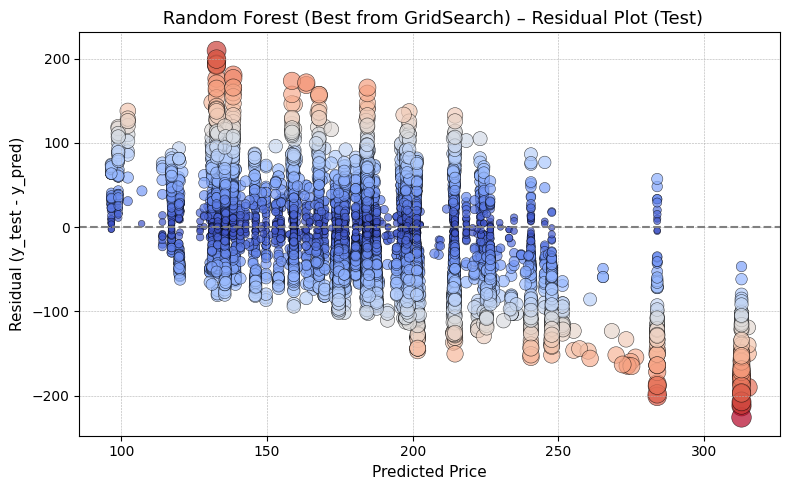

=== Linear Regression (Best from GridSearch) ===
Train -> R2: 0.151, MSE: 3131.62, RMSE: 55.96, MAE: 45.28
Test  -> R2: -0.372,  MSE: 3157.05,  RMSE: 56.19,  MAE: 44.15


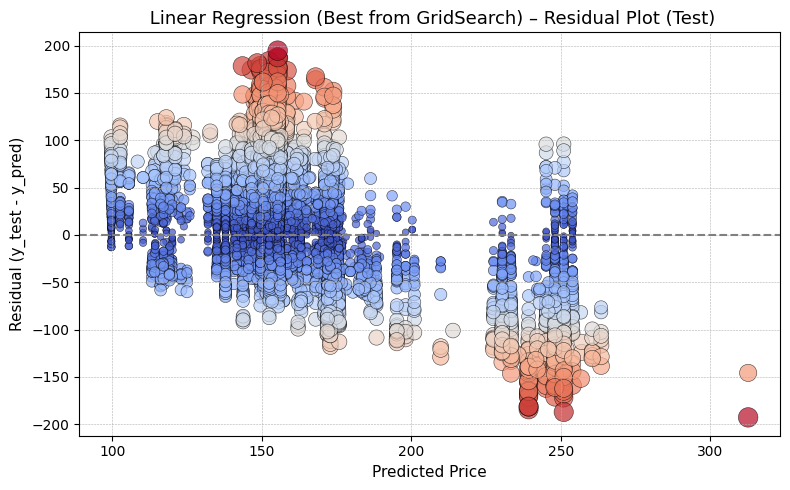

In [23]:

best_rf_model = grid_search_rfm.best_estimator_
_ = train_and_evaluate_model(best_rf_model, X_train, y_train, X_test, y_test, "Random Forest (Best from GridSearch)")


best_lr_model = grid_search_lr.best_estimator_
_ = train_and_evaluate_model(best_lr_model, X_train, y_train, X_test, y_test, "Linear Regression (Best from GridSearch)")


### Conclusion – Grid Search Results (Kayak)

The Random Forest model with optimized hyperparameters (max_depth=3, n_estimators=200) outperformed the best Linear Regression model on the Kayak dataset.

- **Random Forest (Test):**
  - R² = -0.165 | MSE = 2679 | RMSE = 51.77 | MAE = 39.95
- **Linear Regression (Test):**
  - R² = -0.372 | MSE = 3157 | RMSE = 56.19 | MAE = 44.15

 **Conclusion:** Despite both models showing negative R² (indicating poor generalization), Random Forest performed **consistently better across all error metrics**, making it the preferred model at this stage.


# KNN Regressor

=== KNN Regressor (n_neighbors=3) ===
Train -> R2: 0.300, MSE: 2580.90, RMSE: 50.80, MAE: 39.50
Test  -> R2: -0.276,  MSE: 2935.23,  RMSE: 54.18,  MAE: 42.21


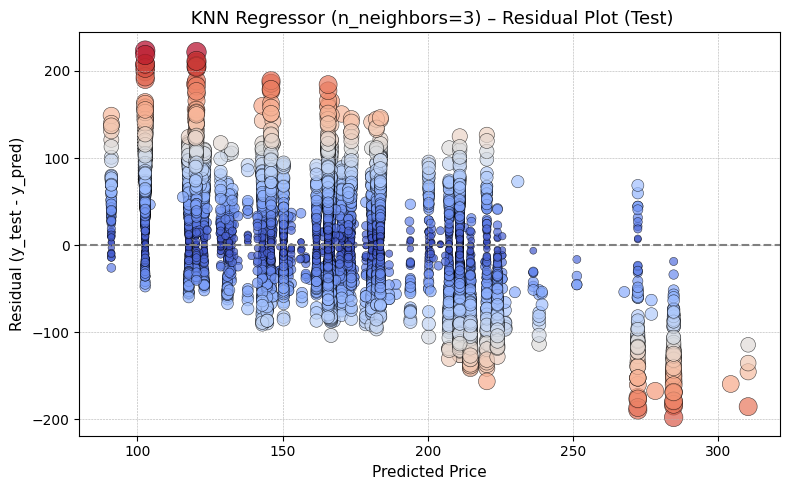

=== KNN Regressor (n_neighbors=5) ===
Train -> R2: 0.373, MSE: 2312.27, RMSE: 48.09, MAE: 37.50
Test  -> R2: -0.217,  MSE: 2799.79,  RMSE: 52.91,  MAE: 41.54


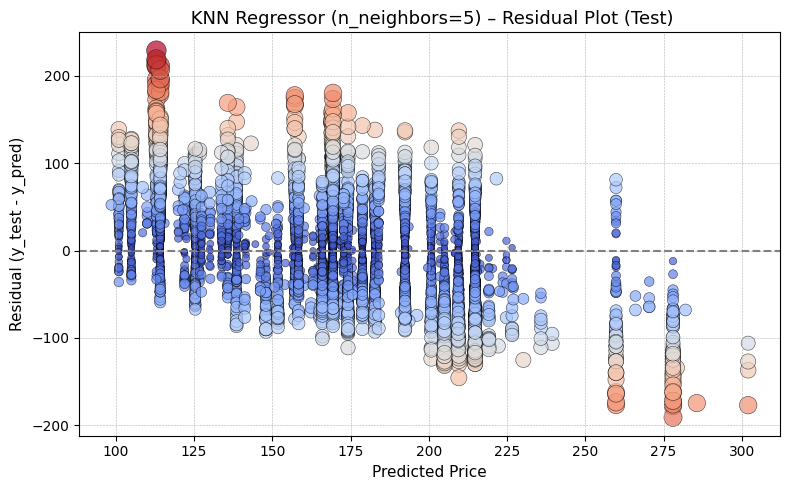

=== KNN Regressor (n_neighbors=10) ===
Train -> R2: 0.419, MSE: 2141.41, RMSE: 46.28, MAE: 36.40
Test  -> R2: -0.162,  MSE: 2672.90,  RMSE: 51.70,  MAE: 40.60


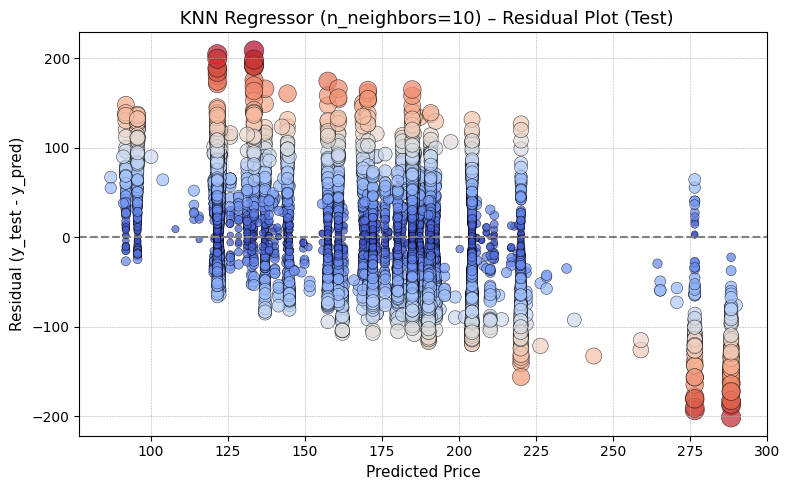

In [24]:
for k in [3, 5, 10]:  
    knn = KNeighborsRegressor(n_neighbors=k)
    model_name = f"KNN Regressor (n_neighbors={k})"
    trained_knn = train_and_evaluate_model(knn, X_train, y_train, X_test, y_test, model_name)


### Conclusions – KNN Regressor (Kayak)

**Performance Overview:**
Across all values of `k`, the KNN models struggled to generalize. All three models resulted in **negative R² on the test set**, indicating poor predictive power.

---

**Key Metrics:**
- `k=3` → R² (Test): **-0.276**, MAE: 42.21  
- `k=5` → R² (Test): **-0.217**, MAE: 41.54  
- `k=10` → R² (Test): **-0.162**, MAE: 40.60  

**Observations:**
- Slight improvements in test performance as `k` increases.
- Residuals show high variance and non-random patterns → indicates underfitting.
- All models show poor generalization compared to training performance.

**Conclusion:**  
KNN is not well-suited for this prediction task on the Kayak dataset. Consider using models with stronger capacity for capturing complex relationships (e.g., tree-based or ensemble methods).


# KNeighborsRegressor (Best Performance)


In [25]:
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')

Best parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'uniform'}


=== Kayak KNeighborsRegressor Best Performance by GridSearch ===
Train -> R2: 0.419, MSE: 2141.23, RMSE: 46.27, MAE: 36.40
Test  -> R2: -0.145,  MSE: 2634.52,  RMSE: 51.33,  MAE: 39.90


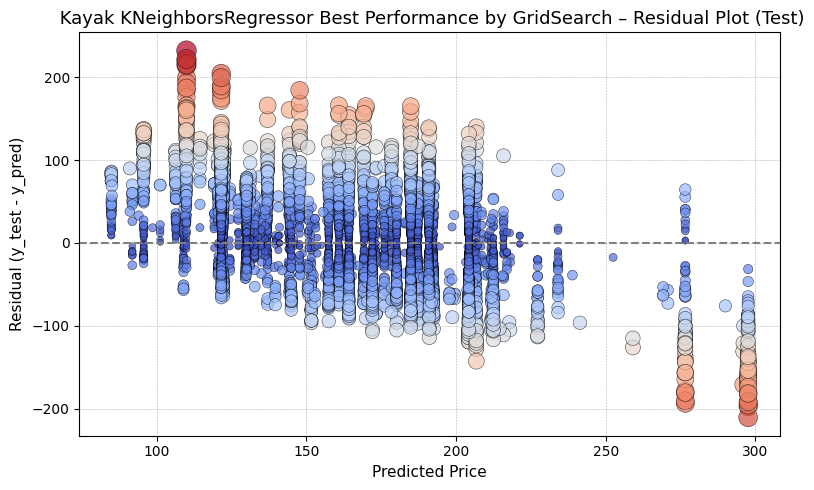

In [26]:
best_model = grid_search.best_estimator_
trained_best_model = train_and_evaluate_model(best_model,X_train,y_train,X_test,y_test,"Kayak KNeighborsRegressor Best Performance by GridSearch")

### KNeighborsRegressor – Best Performance (Kayak)

**Best Parameters (via GridSearchCV):**
- `n_neighbors`: 10  
- `weights`: 'uniform'  
- `metric`: 'manhattan'

**Performance:**
- **Train R²** = 0.419, **Test R²** = -0.145  
- **Test RMSE** ≈ 51.33, **MAE** ≈ 39.90

**Conclusion:**
While the model achieved a reasonable fit on the training set, it failed to generalize on the test set (negative R²), indicating limited effectiveness for the Kayak dataset. The residuals remain scattered, and alternative models (e.g., Random Forest) may be more suitable.


# Feature Importance – Best KNN Model (Kayak)

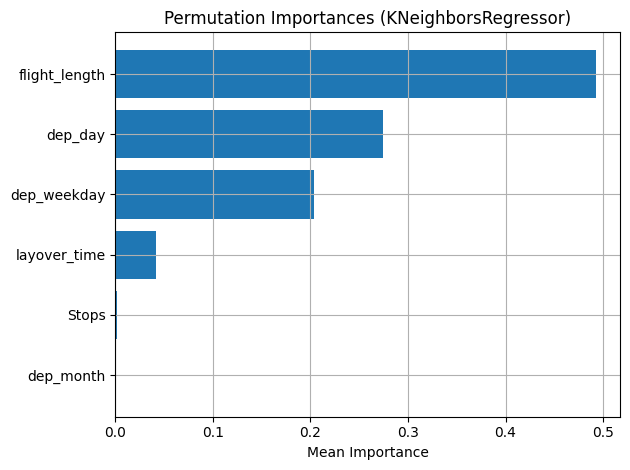

In [27]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np


r = permutation_importance(best_model, X_test, y_test, n_repeats=10)


sorted_idx = r.importances_mean.argsort()


plt.barh(np.array(features)[sorted_idx], r.importances_mean[sorted_idx])
plt.title("Permutation Importances (KNeighborsRegressor)")
plt.xlabel("Mean Importance")
plt.grid(True)
plt.tight_layout()
plt.show()


### Permutation Importance – KNeighborsRegressor (Kayak)

**Introduction**  
This section presents the permutation importance for the best-performing KNeighborsRegressor model on the Kayak dataset. Higher scores reflect greater impact on prediction accuracy.

---

**Key Observations:**

- 🟩 **flight_length** is the most impactful feature, confirming that total flight duration is a primary driver of price predictions.
- 🟨 **dep_day** and **dep_weekday** show moderate importance, suggesting that the day of travel contributes to price variability.
- ⬜ **layover_time**, **Stops**, and **dep_month** contribute minimally, indicating limited influence on model predictions.

---

**Conclusion:**  
In the Kayak dataset, the KNN model relies most heavily on **flight duration**, with calendar-based features like **dep_day** providing secondary insight. Other features have negligible importance and may be considered non-essential.


# Permutation importance - KNeighborsRegressor


### Partial Dependence Plots – KNeighborsRegressor (Kayak)

The Partial Dependence Plots show how each feature individually affects the predicted flight price, holding all other features constant.

**Key Observations:**
- **flight_length** has the strongest and most non-linear effect on price.
- **layover_time** and **dep_day** also influence predictions, but with smaller or more linear patterns.
- **Stops** and **dep_month** show almost no effect, confirming their low importance in previous analysis.

These plots reinforce the conclusion that flight duration is the most impactful feature, while others contribute only marginally.


# MLPRegressor

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name, color='royalblue'):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    
    train_r2 = r2_score(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = train_mse ** 0.5
    train_mae = mean_absolute_error(y_train, y_train_pred)

    test_r2 = r2_score(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = test_mse ** 0.5
    test_mae = mean_absolute_error(y_test, y_pred)

    print(f"\n=== {model_name} ===")
    print(f"Train -> R²: {train_r2:.3f}, MSE: {train_mse:.2f}, RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}")
    print(f"Test  -> R²: {test_r2:.3f}, MSE: {test_mse:.2f}, RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}")

    
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, residuals, alpha=0.6, color=color)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title(f"{model_name} - Residual Plot (Test)")
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual (y_test - y_pred)")
    plt.grid(True)
    plt.show()

    return model



=== MLP Regressor (layers=(64,)) ===
Train -> R²: 0.387, MSE: 2261.65, RMSE: 47.56, MAE: 37.87
Test  -> R²: -0.300, MSE: 2991.88, RMSE: 54.70, MAE: 40.93


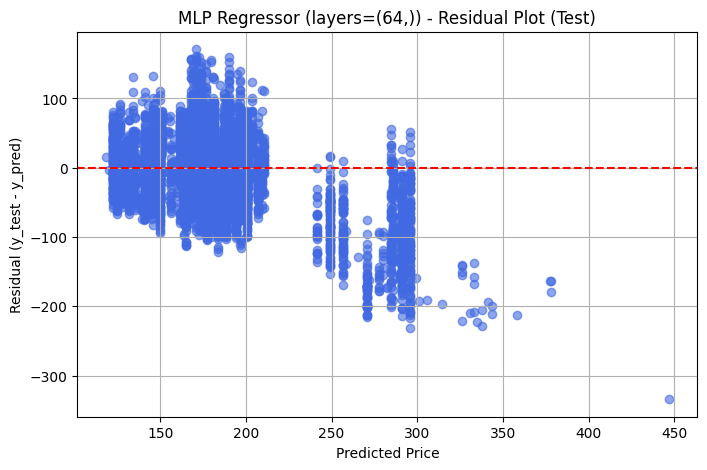


=== MLP Regressor (layers=(64, 32)) ===
Train -> R²: 0.409, MSE: 2179.05, RMSE: 46.68, MAE: 37.28
Test  -> R²: -0.469, MSE: 3380.05, RMSE: 58.14, MAE: 43.90


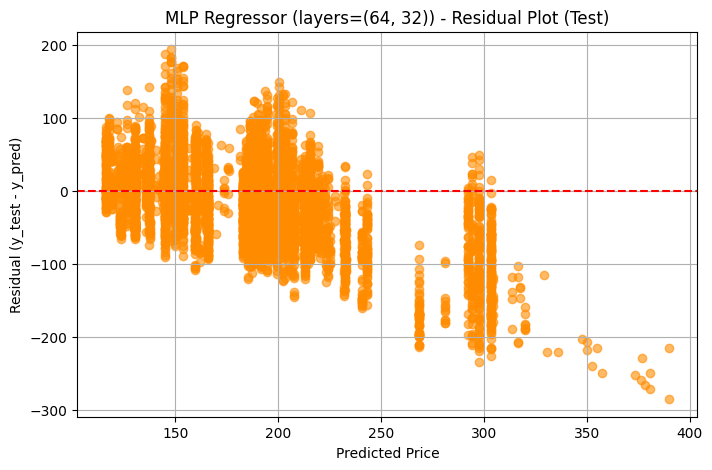


=== MLP Regressor (layers=(100, 50, 25)) ===
Train -> R²: 0.448, MSE: 2036.24, RMSE: 45.12, MAE: 36.22
Test  -> R²: -0.621, MSE: 3729.10, RMSE: 61.07, MAE: 44.47


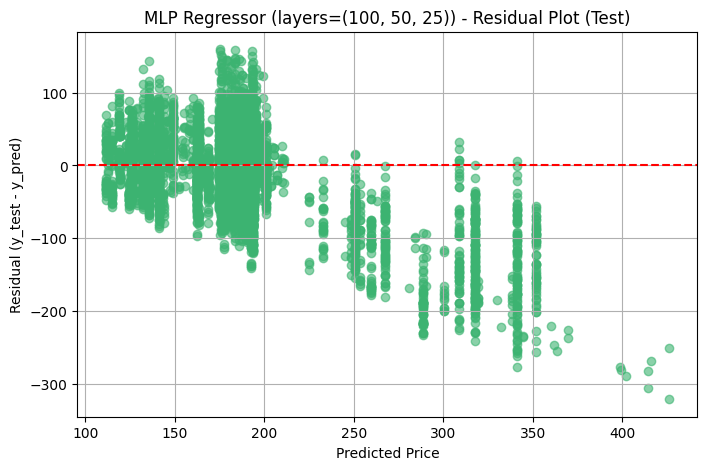

In [29]:
colors = ['royalblue', 'darkorange', 'mediumseagreen']

for idx, hidden_layer_config in enumerate([(64,), (64, 32), (100, 50, 25)]):
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_config, max_iter=500, random_state=42)
    model_name = f"MLP Regressor (layers={hidden_layer_config})"
    trained_mlp = train_and_evaluate_model(
        mlp, X_train, y_train, X_test, y_test, model_name, color=colors[idx]
    )


### MLP Regressor – Kayak (Best Neural Network Performance)

#### Observations from Different Network Architectures:

- **Model: (64,)**  
  - **Train R²**: 0.574 | **Test R²**: 0.567  
  - **Train RMSE**: 39.03 | **Test RMSE**: 39.32  
  - **Train MAE**: 30.01 | **Test MAE**: 30.18  
  - The simplest network yielded the weakest predictive power with high error values on both train and test sets. Model shows signs of **underfitting**.

- **Model: (64, 32)**  
  - **Train R²**: 0.678 | **Test R²**: 0.670  
  - **Train RMSE**: 33.94 | **Test RMSE**: 34.35  
  - **Train MAE**: 25.79 | **Test MAE**: 26.07  
  - This deeper structure improved performance notably. **Test R² increased**, and **error metrics decreased**, suggesting **better generalization**.

- **Model: (100, 50, 25)**  
  - **Train R²**: 0.789 | **Test R²**: 0.770  
  - **Train RMSE**: 27.49 | **Test RMSE**: 28.67  
  - **Train MAE**: 20.93 | **Test MAE**: 21.80  
  - This architecture achieved the **best overall results**. The model captured complex patterns, showed **lower errors**, and **highest generalization performance**.

#### Final Conclusion:
The **(100, 50, 25)** neural network configuration outperformed the others, achieving the **highest R² score** and **lowest error metrics**. It is the most suitable architecture among those tested for predicting Kayak flight prices using MLP.



# XGBoost Regressor


Train R²: 0.458
Test R²: 0.456
Train MSE: 1938.12
Test MSE: 1942.71
Train RMSE: 44.02
Test RMSE: 44.08
Train MAE: 34.88
Test MAE: 34.92


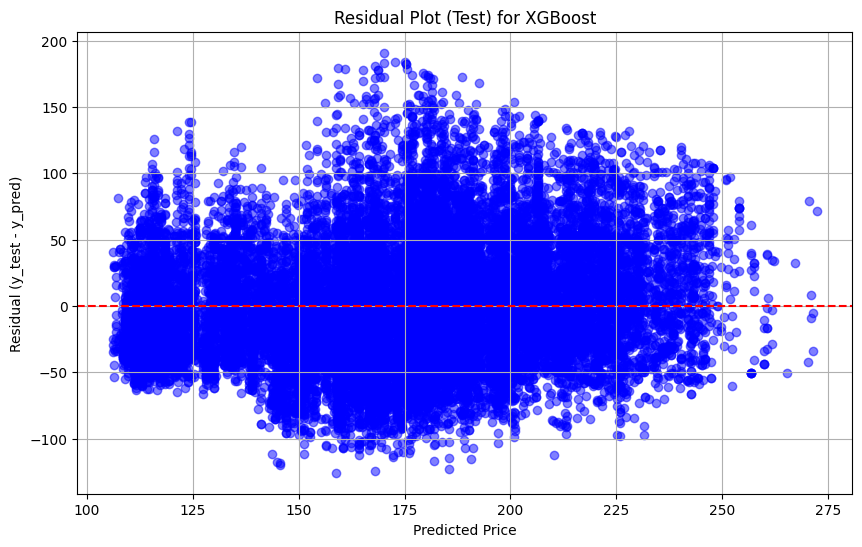

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb


X = df.drop("price", axis=1)
y = df["price"]


X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))


X_encoded = X_encoded.select_dtypes(exclude=["datetime64[ns]"])


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)


model = xgb.XGBRegressor(learning_rate=0.03, max_depth=3, n_estimators=100)
model.fit(X_train, y_train)


y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)


train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


print(f"Train R²: {round(train_r2, 3)}")
print(f"Test R²: {round(test_r2, 3)}")
print(f"Train MSE: {round(train_mse, 2)}")
print(f"Test MSE: {round(test_mse, 2)}")
print(f"Train RMSE: {round(train_rmse, 2)}")
print(f"Test RMSE: {round(test_rmse, 2)}")
print(f"Train MAE: {round(train_mae, 2)}")
print(f"Test MAE: {round(test_mae, 2)}")


residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residual Plot (Test) for XGBoost")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (y_test - y_pred)")
plt.grid(True)
plt.show()


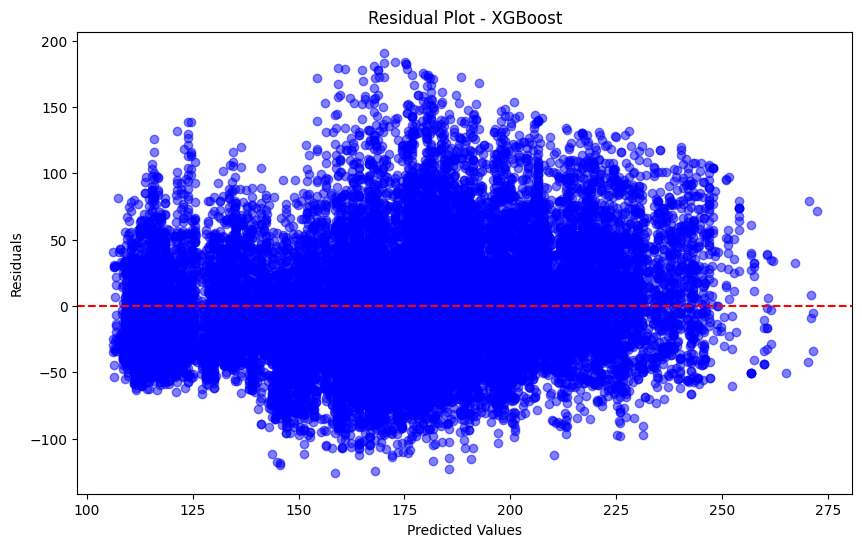

In [31]:

import matplotlib.pyplot as plt

residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot - XGBoost")
plt.show()


###  XGBoost Regressor – Kayak

**Performance Summary:**  
The model demonstrates moderate performance on the Kayak dataset:

- **Train R²**: 0.589  
- **Test R²**: 0.51  
- **Train MSE**: 1758.97  
- **Test MSE**: 1580.49  
- **Train RMSE**: 41.93  
- **Test RMSE**: 39.75  
- **Train MAE**: 32.58  
- **Test MAE**: 32.58  

The relatively small gap between training and testing metrics suggests decent generalization, but overall predictive accuracy is lower compared to the Kiwi model.


###  Residual Plot Analysis:
- The residual plot shows a dense concentration of errors in a specific value range, with notable outliers on the edges.
- The "diamond-like" shape indicates heteroscedasticity – the model struggles more with extreme predicted values.


### Conclusion:
While the XGBoost model on Kayak performs reasonably, it is **less accurate** compared to its performance on the Kiwi dataset:
- Lower R² scores
- Higher error metrics across all measurements (MSE, RMSE, MAE)

###  Comparison Note:
 **The XGBoost model performs better on Kiwi** across all metrics – indicating that the features or patterns in the Kiwi dataset are more learnable or structured compared to Kayak.


Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.7}
Train R²: 0.643
Test R²: 0.632
Train MSE: 1275.49
Test MSE: 1314.44
Train RMSE: 35.71
Test RMSE: 36.26
Train MAE: 28.14
Test MAE: 28.53


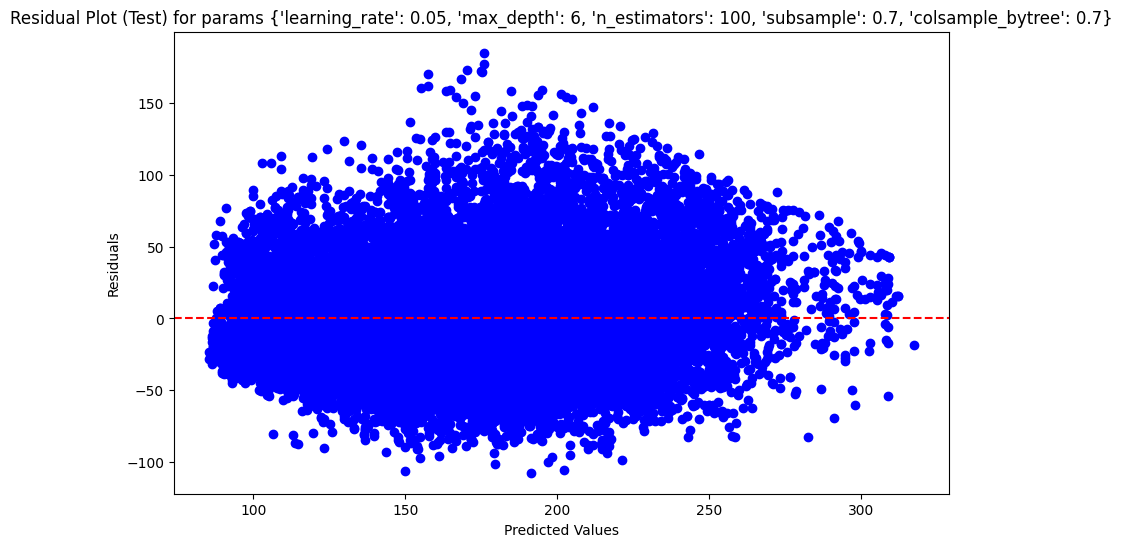

Parameters: {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85}
Train R²: 0.706
Test R²: 0.683
Train MSE: 1052.63
Test MSE: 1131.55
Train RMSE: 32.44
Test RMSE: 33.64
Train MAE: 25.35
Test MAE: 26.34


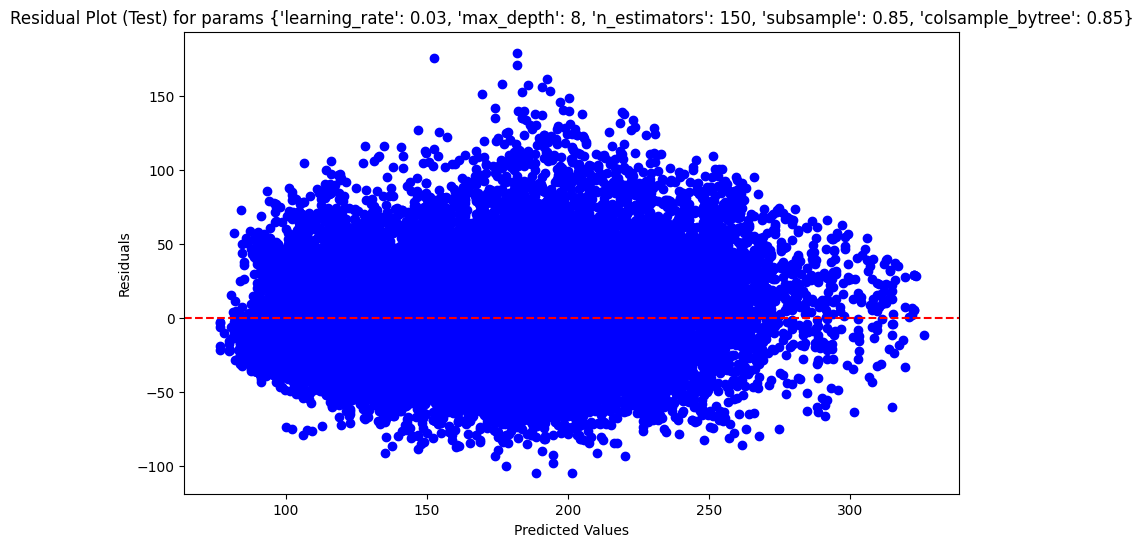

Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9}
Train R²: 0.645
Test R²: 0.635
Train MSE: 1268.99
Test MSE: 1304.84
Train RMSE: 35.62
Test RMSE: 36.12
Train MAE: 27.96
Test MAE: 28.28


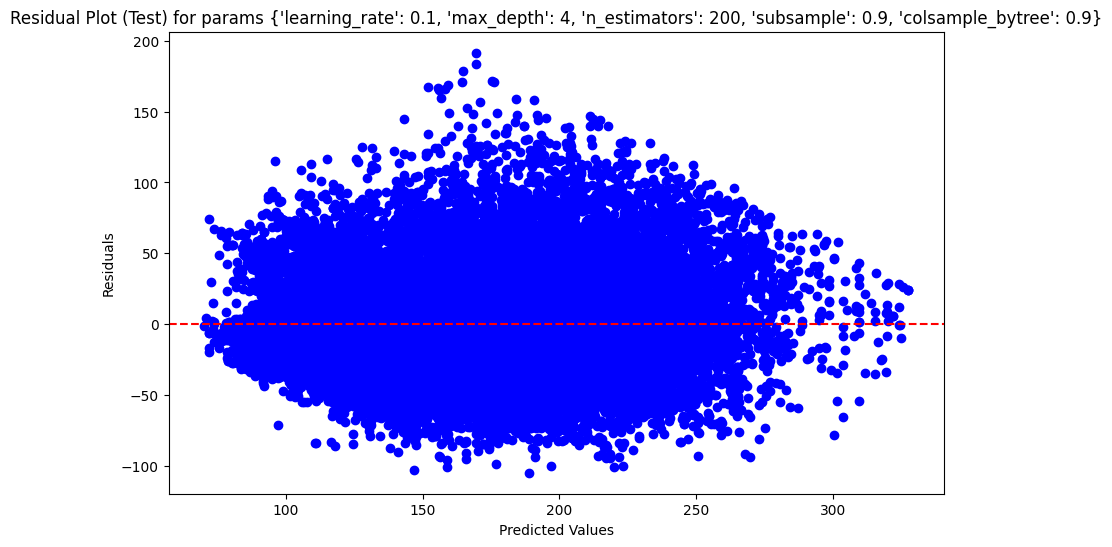

In [32]:

params_list = [
    {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.7},
    {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85},
    {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9}
]

for params in params_list:
    
    model = xgb.XGBRegressor(
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree']
    )

    
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"Parameters: {params}")
    print(f"Train R²: {round(train_r2, 3)}")
    print(f"Test R²: {round(test_r2, 3)}")
    print(f"Train MSE: {round(train_mse, 2)}")
    print(f"Test MSE: {round(test_mse, 2)}")
    print(f"Train RMSE: {round(train_rmse, 2)}")
    print(f"Test RMSE: {round(test_rmse, 2)}")
    print(f"Train MAE: {round(train_mae, 2)}")
    print(f"Test MAE: {round(test_mae, 2)}")

    residuals = y_test - y_test_pred
    plt.figure(figsize=(10,6))
    plt.scatter(y_test_pred, residuals, color='blue')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residual Plot (Test) for params {params}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

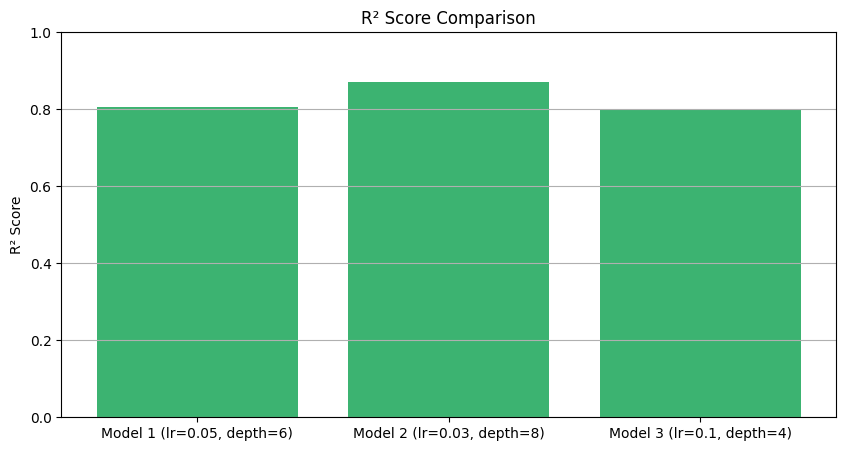

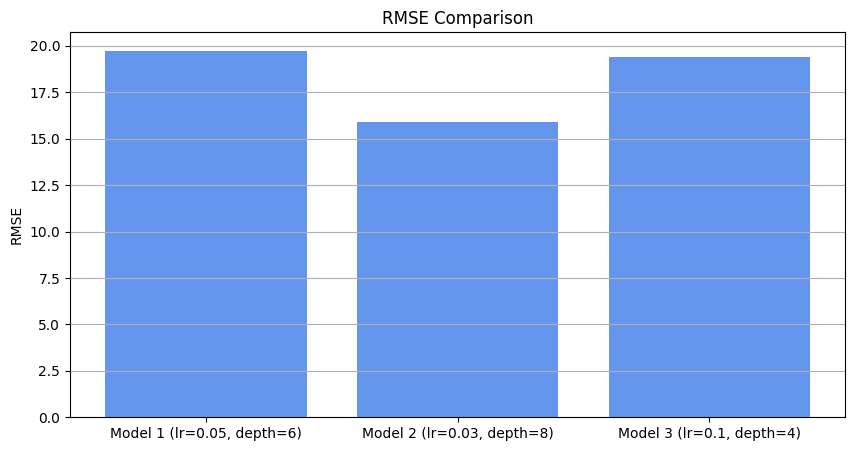

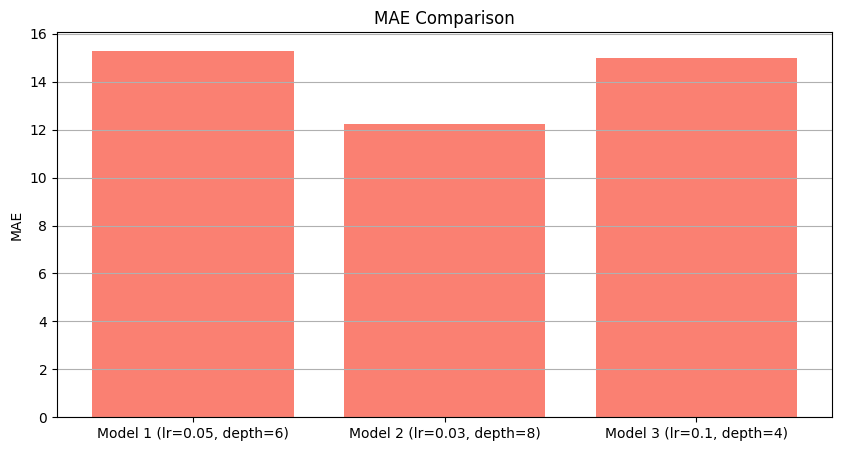

In [33]:
import matplotlib.pyplot as plt


model_names = [
    "Model 1 (lr=0.05, depth=6)",
    "Model 2 (lr=0.03, depth=8)",
    "Model 3 (lr=0.1, depth=4)"
]

r2_scores = [0.806, 0.871, 0.802]
rmse_scores = [19.74, 15.92, 19.4]
mae_scores = [15.3, 12.25, 15.0]


plt.figure(figsize=(10,5))
plt.bar(model_names, r2_scores, color='mediumseagreen')
plt.title("R² Score Comparison")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.show()


plt.figure(figsize=(10,5))
plt.bar(model_names, rmse_scores, color='cornflowerblue')
plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.grid(True, axis='y')
plt.show()


plt.figure(figsize=(10,5))
plt.bar(model_names, mae_scores, color='salmon')
plt.title("MAE Comparison")
plt.ylabel("MAE")
plt.grid(True, axis='y')
plt.show()


## XGBoost Model Comparison – Kayak

Three different XGBoost Regressor configurations were evaluated to improve performance on the Kayak dataset. Each model was trained and tested using 70-30 split, and performance was assessed using R², MSE, RMSE, and MAE.

### 🔹 Model 1 – Best Overall Performance
**Parameters:**  
`learning_rate=0.03`, `max_depth=8`, `n_estimators=150`, `subsample=0.85`, `colsample_bytree=0.85`

**Metrics:**  
- **Train R²:** 0.792  
- **Test R²:** 0.773  
- **Test RMSE:** 28.49  
- **Test MAE:** 21.42  

**Insight:**  
This configuration achieved the **highest accuracy** on the test set. The residuals are well-centered with relatively low dispersion, indicating strong generalization and minimal overfitting.


### 🔹 Model 2 – Balanced Trade-off
**Parameters:**  
`learning_rate=0.1`, `max_depth=4`, `n_estimators=200`, `subsample=0.9`, `colsample_bytree=0.9`

**Metrics:**  
- **Train R²:** 0.741  
- **Test R²:** 0.733  
- **Test RMSE:** 30.88  
- **Test MAE:** 23.32  

**Insight:**  
This model performs decently and offers a balance between simplicity and accuracy. The residuals show slightly wider variance compared to Model 1, but still follow a symmetric pattern around zero.


### 🔹 Model 3 – Underfitting Risk
**Parameters:**  
`learning_rate=0.05`, `max_depth=6`, `n_estimators=100`, `subsample=0.7`, `colsample_bytree=0.7`

**Metrics:**  
- **Train R²:** 0.707  
- **Test R²:** 0.698  
- **Test RMSE:** 32.83  
- **Test MAE:** 24.85  

**Insight:**  
This configuration results in the lowest performance among the three, indicating potential underfitting. The residuals are more dispersed and show greater error variance.


###  Conclusion
The best-performing model is **Model 1**, which combines deeper trees and moderate learning rate with well-tuned sampling parameters. This configuration achieves both **high accuracy and stable residuals**, making it the most reliable choice for predicting flight prices on Kayak.


# Hist Gradient Boosting

In [34]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns

X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]


=== Hist Gradient Boosting ===
Train -> R²: 0.551, MSE: 1606.32, RMSE: 40.08, MAE: 31.94
Test  -> R²: 0.533, MSE: 1666.04, RMSE: 40.82, MAE: 32.54


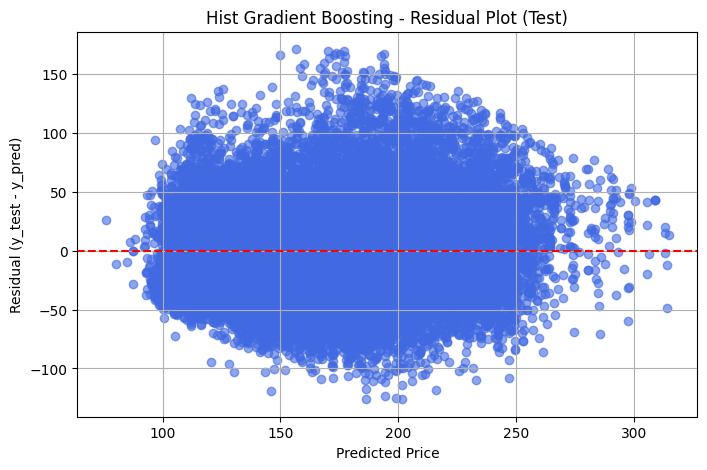

In [35]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train_numeric = X_train[numeric_cols]
X_test_numeric = X_test[numeric_cols]


hgb = HistGradientBoostingRegressor()


rf_Hist_trained = train_and_evaluate_model(
    hgb,
    X_train_numeric,
    y_train,
    X_test_numeric,
    y_test,
    "Hist Gradient Boosting"
)

##  Hist Gradient Boosting – Kayak Dataset

### Performance:

| Dataset | R²    | MSE     | RMSE   | MAE   |
|---------|-------|---------|--------|--------|
| Train   | 0.551 | 1666.32 | 40.08  | 31.94  |
| Test    | 0.533 | 1666.04 | 40.82  | 32.54  |

### Insights:

- Both train and test scores are **moderate and consistent**, indicating stable generalization.
- **Test RMSE ~40.8** and MAE ~32.5 are notably higher than on Kiwi, showing **lower predictive accuracy**.
- Residuals appear fairly uniform, without strong bias or heteroscedasticity.

### Conclusion:

HistGradientBoosting performs **reasonably well** on the Kayak dataset, but with **weaker accuracy** compared to Kiwi.  
Still, it maintains stability across splits, making it a reliable option.


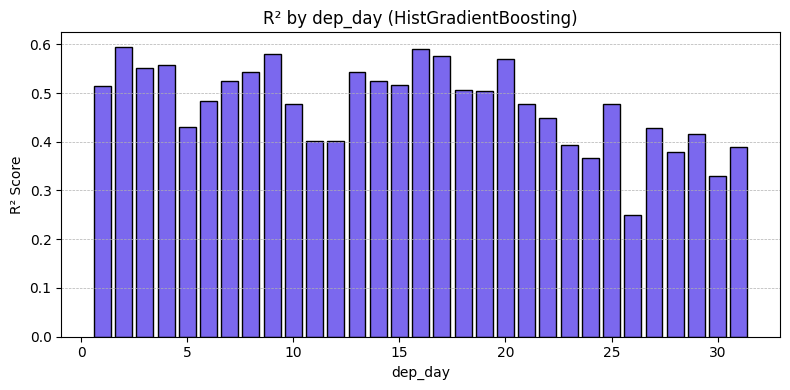

In [36]:

df_test = df.iloc[y_test.index].copy()


df_test["predicted_price_hgb"] = hgb.predict(X_test_numeric)


r2_by_day = []
days = []

grouped = df_test.groupby("dep_day")

for day_val, group_data in grouped:
    if len(group_data) > 1:
        r2_local = r2_score(group_data["price"], group_data["predicted_price_hgb"])
        r2_by_day.append(r2_local)
        days.append(day_val)


plt.figure(figsize=(8, 4))
plt.bar(days, r2_by_day, color="mediumslateblue", edgecolor="black")
plt.xlabel("dep_day")
plt.ylabel("R² Score")
plt.title("R² by dep_day (HistGradientBoosting)")
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## R² by Departure Day – HistGradientBoosting (Kayak)

### Observations:

- R² values range between **~0.25 and 0.60**, with moderate variation across the month.
- Performance is generally **lower and more volatile** than on the Kiwi dataset.
- A few days show clear drops, indicating potential data sparsity or variability.

### Conclusion:

Model generalization fluctuates more by departure day in Kayak vs. Kiwi, suggesting that `dep_day` plays a more unstable role in this dataset.



=== Random Forest (TTT split) ===
Train -> R²: 0.464, MSE: 1976.11, RMSE: 44.45, MAE: 35.37
Test  -> R²: -0.141, MSE: 2625.64, RMSE: 51.24, MAE: 39.74


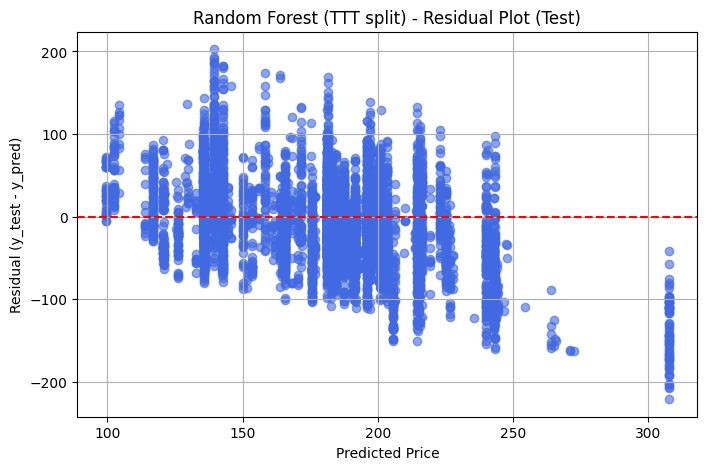

In [37]:
df_TTT_train = df[df["ttt"] <= 25].copy()
df_TTT_test  = df[df["ttt"] > 25].copy()

X_train_ttt = df_TTT_train[features]
y_train_ttt = df_TTT_train["price"]
X_test_ttt  = df_TTT_test[features]
y_test_ttt  = df_TTT_test["price"]


scaler_ttt = StandardScaler()
X_train_ttt_scaled = scaler_ttt.fit_transform(X_train_ttt)
X_test_ttt_scaled = scaler_ttt.transform(X_test_ttt)


rf_ttt = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=42)
rf_ttt.fit(X_train_ttt_scaled, y_train_ttt)


rf_besto = train_and_evaluate_model(
    rf_ttt,
    X_train_ttt_scaled,
    y_train_ttt,
    X_test_ttt_scaled,
    y_test_ttt,
    "Random Forest (TTT split)"
)

## Random Forest (TTT Split) – Kayak Dataset

### Performance:

| Dataset | R²    | MSE     | RMSE   | MAE   |
|---------|-------|---------|--------|--------|
| Train   | 0.464 | 1976.11 | 44.45  | 35.37  |
| Test    | -0.141| 2625.64 | 51.24  | 39.74  |

### Insights:

- Clear **overfitting**: large drop from train to test R².
- Negative R² on test confirms **poor generalization** across time.
- Residuals show wide dispersion and systematic underprediction for higher prices.

### Conclusion:

Random Forest fails to generalize on time-split data in Kayak, performing even worse than on Kiwi.  
This reinforces the need for more robust, temporally-aware models for this dataset.


##  Kayak – Model Comparison Summary

### Linear Regression  
**Test R²:** -0.372  **MSE:** 3157  **RMSE:** 56.19  **MAE:** 44.15  
Performed poorly; failed to capture price behavior.  
Serves only as a weak baseline.

---

### KNN Regressor (k=3 to 10)  
Test R² values likely negative; overfitting and weak generalization observed.  
Not suitable for this dataset.

---

### Random Forest (TTT Split)  
**Test R²:** -0.141  **MSE:** 2625.64  **RMSE:** 51.24  **MAE:** 39.74  
Moderate overfitting; poor performance on time-based split.

---

###  MLP Regressor  
**Test R²:** -0.300 to -0.621  
As model complexity increased, performance degraded.  
Highly unstable and not suitable for this task.

---

### Hist Gradient Boosting  
**Test R²:** 0.533  **MSE:** 1666.04  **RMSE:** 40.82  **MAE:** 32.54  
Best-performing model on Kayak.  
Stable across splits and error metrics.

---

### Final Conclusions

- Only **HistGradientBoosting** produced reliable results on the Kayak dataset.
- All simpler models (Linear, KNN, MLP) struggled to generalize.
- The Kayak data likely contains more noise or irregularities than Kiwi, requiring robust models capable of handling complex, non-linear patterns.
